Collab Link : https://colab.research.google.com/drive/17WIUk4ptqaLnSUZv-7GR3excynr3OuJL?usp=sharing

# The Notebook contains code to evaluate our fine tuned T5 model- Evaluation Metrics used : N-gram simmilarity and Semantic Similarity.

# Imports

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install -U sentence-transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction
from transformers import T5ForConditionalGeneration,T5Tokenizer
from nltk.util import ngrams
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
import pandas as pd
from sentence_transformers import SentenceTransformer,util

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%mv "/content/drive/MyDrive/Colab Notebooks/Copy of Evaluation-T5 Model.ipynb" 

# T5 Paraphrase Generator Model

In [ ]:
my_tokenizer = T5Tokenizer.from_pretrained('t5-base')
my_model = T5ForConditionalGeneration.from_pretrained('./drive/MyDrive/IRE/Paraphrase_Generation/t5_paraphrase')
my_model.to("cuda")

# N-gram Similarity Calculation

## BLEU Score

In [ ]:
def compute_BLEU(text1, text2):
  ref = [ word_tokenize(text1.lower()) ]
  out = word_tokenize(text2.lower())
  score = sentence_bleu(ref, out, smoothing_function=SmoothingFunction().method4)
  return score

## PINC Score

In [ ]:
def compare(text1,text2,n):
  trigrams1 = ngrams(text1.lower().split(), n)
  trigrams2 = ngrams(text2.lower().split(), n)
  trigrams1 = [x for x in trigrams1]
  trigrams2 = [x for x in trigrams2]
  common=[]
  for grams1 in trigrams1:
    if grams1 in trigrams2:
      common.append(grams1)
      
  return common, len(trigrams2) 

def compute_PINC(text1, text2, N):
  pinc_score = 0
  for i in range(1,N+1):
    grams_list, candidate_length = compare(text1,text2,i)
    cabo = 1 - (len(grams_list)/candidate_length)
    pinc_score += cabo
  pinc_score = pinc_score/N
  return pinc_score

## Word Similarity Score

In [ ]:
def word_similarity(sent1, sent2):
  bleu_score = compute_BLEU(sent1, sent2)
  pinc_score = compute_PINC(sent1, sent2, 4)
  
  return (bleu_score + (1 - pinc_score))/ 2

# Generate Paraphrases

In [ ]:
def generate(model, tokenizer, sentence):


  text = "paraphrase: " + sentence
  max_len = 256

  encoding = tokenizer.encode_plus(text,padding='max_length', return_tensors="pt")
  input_ids, attention_masks = encoding["input_ids"].to("cuda"), encoding["attention_mask"].to("cuda")
  

  outputs = model.generate(
    input_ids=input_ids, 
    attention_mask=attention_masks,
    do_sample=True,
    max_length=256,
    top_k=220,
    top_p=0.9,
    early_stopping=True,
    num_return_sequences=20
  )



  final_outputs = []

  for output in outputs:
      sent = tokenizer.decode(output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
      if sent.lower() != sentence.lower() and sent not in final_outputs:
          final_outputs.append(sent) 

  
  return final_outputs
   

# Semantic Similarity

In [ ]:
sbert_model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def semantic_similarity(sentence1, sentence2, sbert_model):

  embeddings1 = sbert_model.encode(sentence1, convert_to_tensor=True)
  embeddings2 = sbert_model.encode(sentence2, convert_to_tensor=True)
  cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

  return (cosine_scores[0][0].cpu().numpy() + 1)/2

# Plot

In [ ]:
test_df = pd.read_csv("./drive/MyDrive/IRE/PAWS_DATA/smaller_subset/paws_test.csv")

In [ ]:
test_sentence = test_df.iloc[10995]['sentence1']
print(test_sentence)

test_sentence2 = test_df.iloc[15]['sentence1']
print(test_sentence2)

All five events started the last day and concluded with the final on the first day .
What are the courses for commence students without maths?


In [ ]:
test_outputs = generate(my_model , my_tokenizer , test_sentence)
test_outputs2 = generate(my_model , my_tokenizer , test_sentence2)

In [ ]:
print("FOR - " , test_sentence , '\n')
for to in test_outputs:
  ws = word_similarity(test_sentence , to)
  if ws <= 0.7:
    print(to , word_similarity(test_sentence , to))

print('\n')
print("FOR - ",test_sentence2 , '\n')
for to in test_outputs2:
  ws = word_similarity(test_sentence2 , to)
  if ws <= 0.7:
    print(to , word_similarity(test_sentence , to))

FOR -  All five events started the last day and concluded with the final on the first day . 

All five events began on the last day and ended with the final on the first day. 0.5766943973291077
All five events started on the last day and ended with the final on the first day. 0.6411804258538856
All five events started the last day and finished the second day with the final. 0.5459722699323786
All five events started on the last day and ended with the final the first day. 0.5221174047768683
All five events began on the last day and concluded on the first day with the final. 0.49467268206470016
All the five events started the last day and ended with the final on the first day. 0.6975724777641634


FOR -  What are the courses for commence students without maths? 

What are the requirements for beginning students without mathematics? 0.09021482232585101
What are the course for commence students without maths? 0.09021482232585101
How can I get started without maths? 0.05002635911862554
What

In [ ]:
data = list(test_df["sentence1"][:1500])

In [ ]:
def generate_score_data(data):
  semantic_score = []
  word_score = []

  for sentence in tqdm(data):

    paraphrases = generate(my_model ,my_tokenizer, sentence)
    for output in paraphrases:
      try:
        if word_similarity(sentence, output) < 0.9:
          word_score.append(word_similarity(sentence, output))
          semantic_score.append(semantic_similarity(sentence, output, sbert_model))
      except:
        continue
  return word_score, semantic_score

In [ ]:
word_sims,semantic_sims = generate_score_data(data)

100%|██████████| 1500/1500 [1:12:47<00:00,  2.91s/it]


In [ ]:
def plot_hist2d(x,y , n_bins):
  nbins = n_bins

  fig = plt.figure(figsize=(10,10))

  plt.hist2d(x , y , bins=nbins , cmap=plt.cm.RdPu_r , cmin=0)
  plt.title("SEMANTIC SIMILARITY VS N-GRAM SIMILARITY")
  plt.xlabel("NGRAM SIMILARITY")
  plt.ylabel("SEMANTIC SIMILARITY")
  plt.ylim([0,1])
  plt.xlim([0,1])
  plt.colorbar()
  ax = plt.axes()
  ax.set_facecolor((0.301,0.176,0.416,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


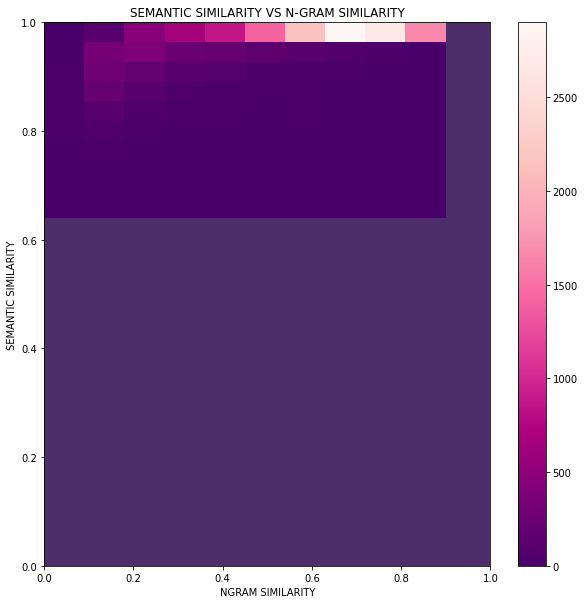

In [ ]:
plot_hist2d(word_sims , semantic_sims , 10)

In [ ]:
word_sims_new = []
semantic_sims_new = []

for i in range(len(word_sims)):
  if word_sims[i] <= 0.6:
    word_sims_new.append(word_sims[i])
    semantic_sims_new.append(semantic_sims[i])

In [ ]:
len(word_sims_new) , len(semantic_sims_new)

(7888, 7888)

#### Filtering out only lower than 0.6 ngram similarity scores

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


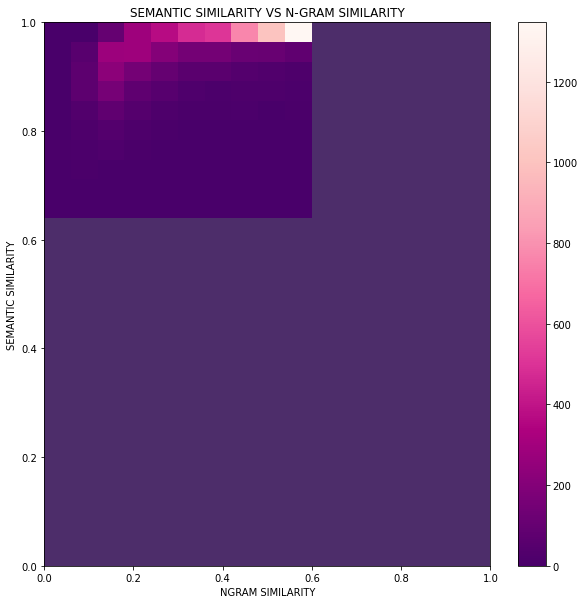

In [ ]:
plot_hist2d(word_sims_new , semantic_sims_new , 10)